# Psuedobulk functional analysis from DESeq2 contrasts with decoupler
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a

# Set-up

In [1]:
# Global Imports
import os
import sys
import yaml
import random
import time
import datetime
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

In [12]:
# Inputs
condition="3-cyt"
indir_path = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2023_11_27/decoupler/pseudobulk_deseq2/2966503918_20231127-151254"
use_shrunk = True
in_file_path = f"{condition}_vs_control_shrunkLFC.tsv" if use_shrunk else f"{condition}_vs_control.tsv"
in_file_path = os.path.join(indir_path, in_file_path)
in_file_path

'/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2023_11_27/decoupler/pseudobulk_deseq2/2966503918_20231127-151254/3-cyt_vs_control_shrunkLFC.tsv'

In [13]:
# Outputs
results_dir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2023_11_27/decoupler"
out_analysis = "functional_analysis"
time_id = time.strftime("%Y%m%d-%H%M%S")
run_id =  random.getrandbits(32)
run = str(run_id) + "_" + time_id
out_dir = os.path.join(results_dir, out_analysis, run)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_dir

'/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/2023_11_27/decoupler/functional_analysis/1939512655_20231129-163240'

In [14]:
# Method params
tf_annotation_resource = "dorothea"
tf_method = "ulm"
tf_additional_args = {}
pathway_annotation_resource = "progeny"
pathway_method = "mlm"
pathway_additional_args = {"top": 500}
gsea_resource = "msigdb"
gsea_method = "ora"
gsea_additional_args = {"padj": 0.05, "top_n": None}

In [15]:
# Make a params file
# Make and log a yaml file with the parameters
data_params = {
    "condition": condition,
    "in_file_path": in_file_path,
    "out_dir": out_dir,
}
tf_activity_params = {
    "tf_annotation_resource": tf_annotation_resource,
    "tf_method": tf_method,
    "tf_additional_args": tf_additional_args,
}
pathway_activity_params = {
    "pathway_annotation_resource": pathway_annotation_resource,
    "pathway_method": pathway_method,
    "pathway_additional_args": pathway_additional_args,
}
gsea_params = {
    "gsea_resource": gsea_resource,
    "gsea_method": gsea_method,
    "gsea_additional_args": gsea_additional_args,
}
version_params = {
    "time_id": time_id,
    "run_id": run_id,
    "Python": sys.version[:5],
    "Scanpy": sc.__version__,
    "decoupler": dc.__version__,
}
params = {"data": data_params, "tf_activity": tf_activity_params, "pathway_activity": pathway_activity_params, "gsea": gsea_params, "version": version_params}
params_file = os.path.join(out_dir,"functional_analysis_params.yaml")
if not os.path.exists(os.path.join(out_dir, params_file)):
    with open(os.path.join(out_dir, params_file), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [16]:
# The data to load in formatted as a 10x directory, change if you have a different format for reading in data
results_df = pd.read_csv(in_file_path, sep="\t", index_col=0)
results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TMEM132D,1254.02400,1.267300,0.039069,32.512404,7.121931e-232,7.916027e-228
STAT1,138.81586,2.912366,0.117573,24.815390,6.115967e-136,3.398949e-132
PBX3,896.88513,-0.576691,0.026242,-22.077402,5.212023e-108,1.931055e-104
DACH1,1242.10730,-0.660911,0.031674,-20.985432,8.911064e-98,2.476162e-94
TMOD1,329.76932,1.321151,0.064298,20.657738,8.316929e-95,1.848853e-91


In [18]:
(results_df["padj"] < 0.05).sum()

3702

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


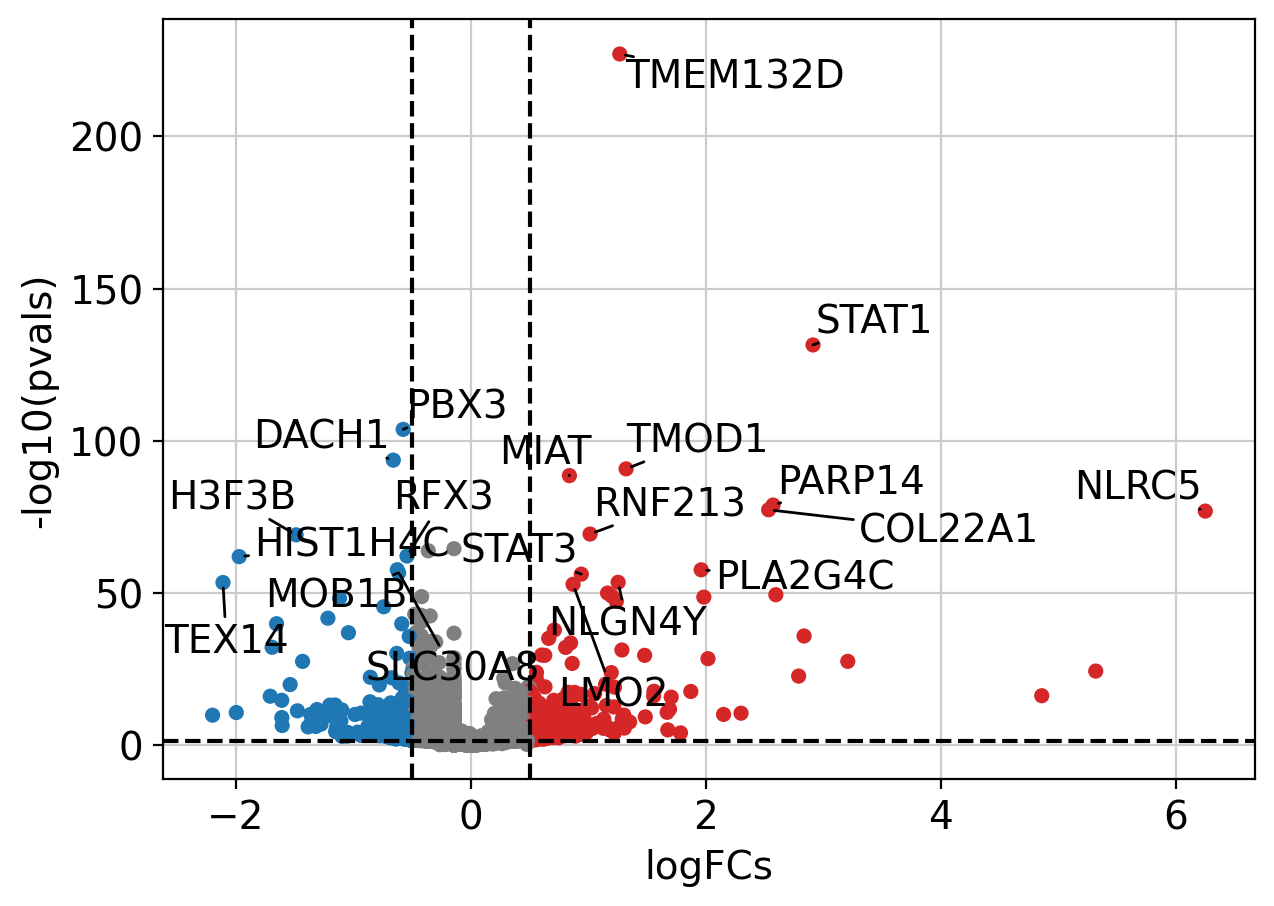

In [11]:
# Replot the volcano plot to make sure it looks good
dc.plot_volcano_df(
    results_df, 
    x='log2FoldChange', 
    y='padj', 
    top=20, 
)

In [15]:
mat = results_df[['stat']].T.rename(index={'stat': "SC_beta"})
mat

,TMEM132D,STAT1,PBX3,DACH1,TMOD1,MIAT,PARP14,COL22A1,NLRC5,RNF213,...,C16orf87,ZBED4,PEMT,SAV1,PTDSS1,PLEKHA1,UTP23,ECPAS,JMJD6,AKAP9
SC_beta,32.512404,24.81539,-22.077402,-20.985432,20.657738,20.401467,19.27343,19.079135,19.021326,18.081054,...,-0.002315,0.0021,-0.002009,0.001627,-0.001609,0.001391,-0.000925,-0.000431,0.000058,0.000103


# TF activity analysis

In [12]:
# Retrieve GRN
if tf_annotation_resource == "dorothea":
    net = dc.get_dorothea(organism='human', split_complexes=False)
else:
    raise ValueError(f"tf_annotation_resource {tf_annotation_resource} not supported")
net.head()

,source,confidence,target,weight
0,MYC,A,TERT,1.0
1,FOS,A,NTS,1.0
2,FOS,A,NTF3,1.0
3,FOS,A,NFKB1,-1.0
4,FOS,A,NEFL,1.0


In [16]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=net)
tf_acts

,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
SC_beta,-4.653743,-2.750493,-5.230255,1.442778,-5.744897,3.441067,-0.542877,-5.070824,-0.34786,-2.268989,...,-2.88938,1.054922,7.920276,-0.028361,-2.269928,1.21477,2.307466,-2.545444,-2.024837,2.481791


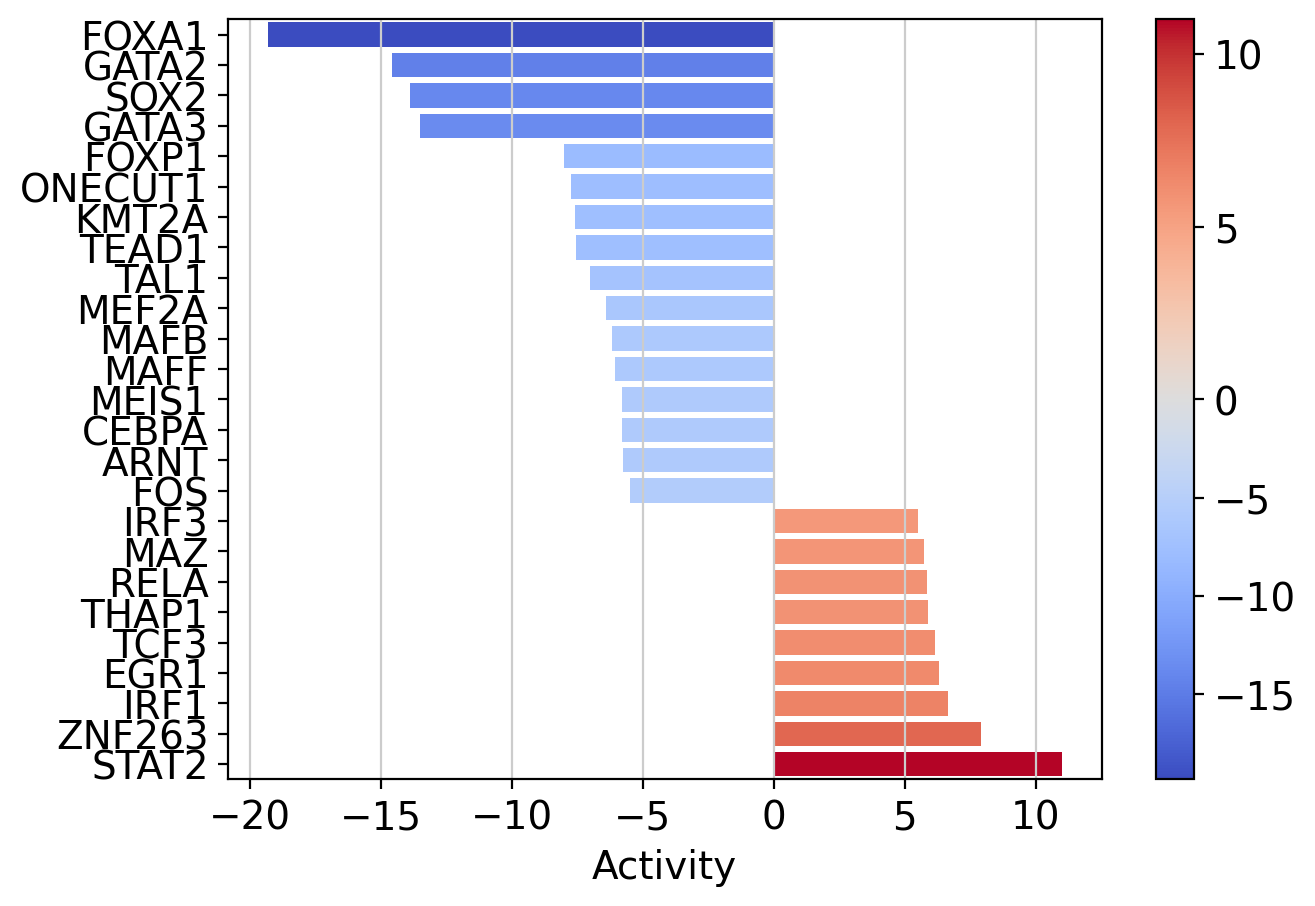

In [17]:
# Plot the TF activity barplot
dc.plot_barplot(tf_acts, "SC_beta", top=25, vertical=True, save=os.path.join(out_dir, f"SC_beta_{condition}_tf_activity_barplot.png"))

In [18]:
# Save the TF activity table
tf_acts.T.to_csv(os.path.join(out_dir, f"SC_beta_{condition}_tf_activity.tsv"), sep="\t")

# Pathway activity analysis

In [19]:
# Retrieve weights
if pathway_annotation_resource == "progeny":
    net = dc.get_progeny(top=pathway_additional_args["top"])
else:
    raise ValueError(f"pathway_annotation_resource {pathway_annotation_resource} not supported")
net.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [20]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=net)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
SC_beta,-3.047723,2.958773,0.161321,-0.97826,12.675016,-1.767177,1.485878,-3.285102,-1.394101,3.221212,-0.725287,2.582699,-0.786219,1.966245


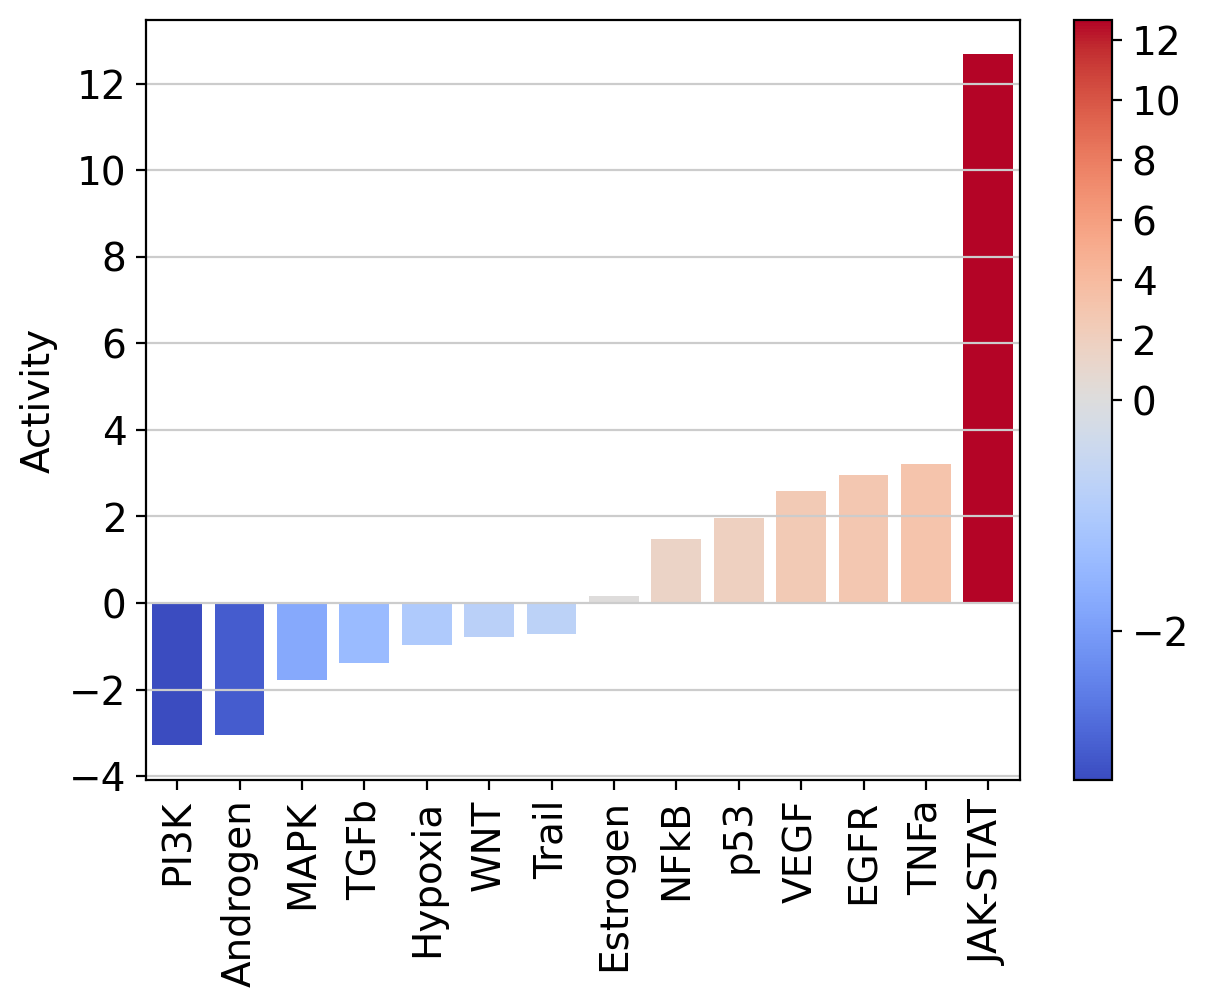

In [21]:
# Plot a barplot of the pathway activities
dc.plot_barplot(pathway_acts, "SC_beta", top=25, vertical=False, save=os.path.join(out_dir, f"SC_beta_{condition}_pathway_activity_barplot.png"))

In [22]:
# Save the pathway activities to a file
pathway_acts.T.to_csv(os.path.join(out_dir, f"SC_beta_{condition}_pathway_activity.tsv"), sep="\t")

# Gene set enrichment analysis

In [41]:
# Retrieve resource
if gsea_resource == "msigdb":
    gene_sets = dc.get_resource('MSigDB')
    
    # Filter by hallmark
    #gene_sets = gene_sets[gene_sets['collection'] == 'hallmark']

    # Remove duplicated entries
    #gene_sets = gene_sets[~gene_sets.duplicated(['geneset', 'genesymbol'])]

    # Rename
    #gene_sets.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in gene_sets['geneset']]

    # Filter by hallmark
    gene_sets = gene_sets[gene_sets['collection']=='kegg_pathways']

    # Remove duplicated entries
    gene_sets = gene_sets[~gene_sets.duplicated(['geneset', 'genesymbol'])]

else:
    raise ValueError(f"gsea_resource {gsea_resource} not supported")
gene_sets.head()

,genesymbol,collection,geneset
2587,ABCA1,kegg_pathways,KEGG_ABC_TRANSPORTERS
3398,TUBB2A,kegg_pathways,KEGG_GAP_JUNCTION
3659,TUBB2A,kegg_pathways,KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION
3937,BMP2,kegg_pathways,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION
3962,BMP2,kegg_pathways,KEGG_TGF_BETA_SIGNALING_PATHWAY


In [42]:
# Infer enrichment with ora using significant deg
if gsea_additional_args["padj"] is None:
    assert gsea_additional_args["top_n"] is not None
    top_genes = results_df.sort_values("padj").iloc[:gsea_additional_args["top_n"]]
else:
    top_genes = results_df[results_df['padj'] < 0.05]
print(top_genes.shape)
top_genes.head()

(3702, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TMEM132D,1254.02400,1.267300,0.039069,32.512404,7.121931e-232,7.916027e-228
STAT1,138.81586,2.912366,0.117573,24.815390,6.115967e-136,3.398949e-132
PBX3,896.88513,-0.576691,0.026242,-22.077402,5.212023e-108,1.931055e-104
DACH1,1242.10730,-0.660911,0.031674,-20.985432,8.911064e-98,2.476162e-94
TMOD1,329.76932,1.321151,0.064298,20.657738,8.316929e-95,1.848853e-91


In [50]:
# Run GSE
enr_pvals = dc.get_gsea_df(
    df=top_genes,
    stat="log2FoldChange",
    net=gene_sets,
    source='geneset',
    target='genesymbol',
)
enr_pvals.head()

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge
0,KEGG_ABC_TRANSPORTERS,0.258935,0.695799,0.828070,0.941442,10,0.200000,0.082118,ABCA7;ABCB1
1,KEGG_ACUTE_MYELOID_LEUKEMIA,0.282566,0.912699,0.535714,0.912698,20,0.300000,0.189627,STAT3;BAD;IKBKB;JUP;PIK3R1;MAP2K2
2,KEGG_ADHERENS_JUNCTION,-0.180068,-0.733853,0.825485,0.941442,33,0.484848,0.321988,CDC42;NECTIN3;WASL;YES1;LMO7;NLK;MAP3K7;SMAD4;...
3,KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,0.228100,0.710287,0.813022,0.941442,17,0.294118,0.189627,STAT3;TRAF2;CAMKK2;IKBKB;STK11
4,KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,-0.588103,-1.292085,0.185430,0.666881,5,0.400000,0.083468,GLS;ASS1


In [58]:
enr_pvals[enr_pvals.Term.str.contains("INSULIN")]

,Term,ES,NES,NOM p-value,FDR p-value,Set size,Tag %,Rank %,Leading edge,size
63,KEGG_INSULIN_SIGNALING_PATHWAY,0.17649,0.70502,0.884494,0.941442,53,0.320755,0.248514,MKNK2;GYS1;SHC3;PHKA2;CRK;SREBF1;PRKACA;SHC2;B...,1


In [59]:
# Keep top 25 based on NES
enr_pvals = enr_pvals.sort_values("NES", ascending=False).iloc[:25]

In [60]:
enr_pvals["size"] = 1

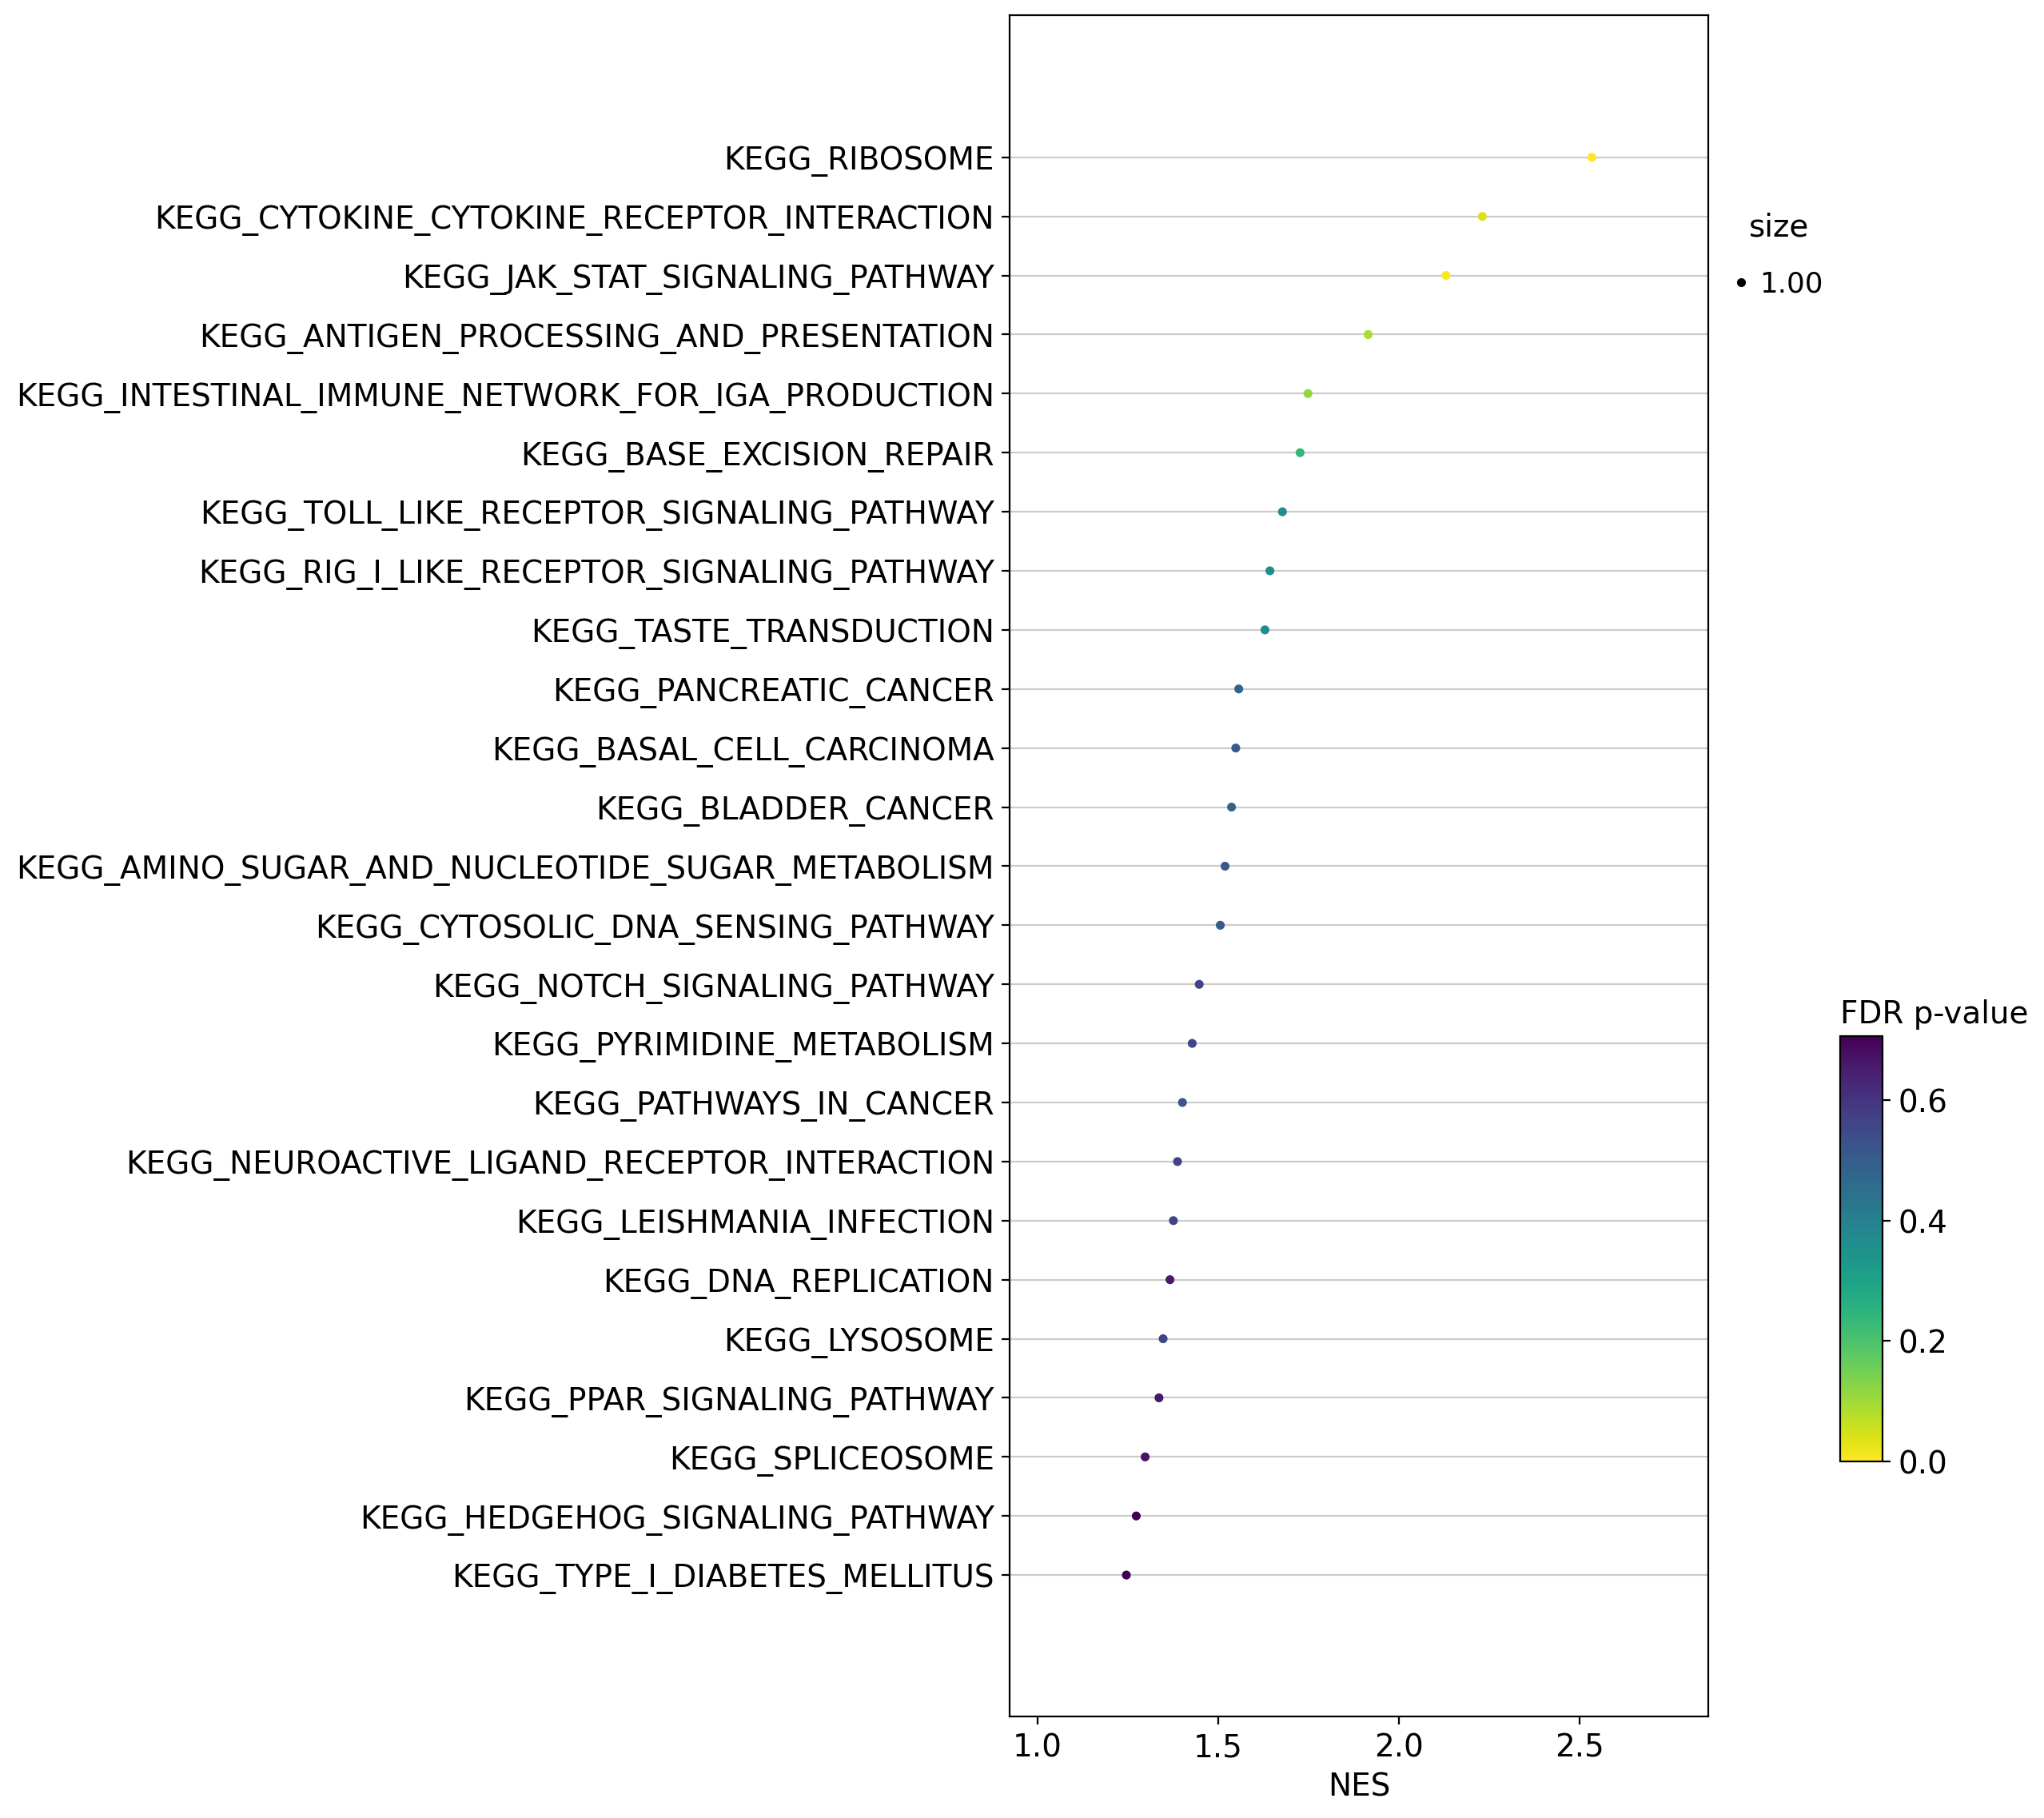

In [61]:
# Plot the dotplot
dc.plot_dotplot(
    enr_pvals, 
    x='NES', 
    y='Term',
    s="size",
    c='FDR p-value', 
    scale = 0.5, 
    figsize=(7,14), 
    save=os.path.join(out_dir, f"SC_beta_{condition}_gsea_dotplot.png")
)

In [62]:
# Run ora
enr_pvals = dc.get_ora_df(
    df=top_genes,
    net=gene_sets,
    source='geneset',
    target='genesymbol'
)
enr_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,KEGG_ABC_TRANSPORTERS,44,0.227273,2.892039e-01,0.578408,1.275244,1.582097,ABCA2;ABCA3;ABCA7;ABCB1;ABCB4;ABCB7;ABCC10;ABC...
1,KEGG_ACUTE_MYELOID_LEUKEMIA,57,0.350877,2.218856e-03,0.014264,1.930833,11.798862,AKT3;BAD;BRAF;GRB2;IKBKB;JUP;KRAS;MAP2K2;MAPK1...
2,KEGG_ADHERENS_JUNCTION,73,0.452055,1.492670e-07,0.000007,2.475161,38.903411,ACTN4;AFDN;CDC42;CDH1;CTNNA2;CTNNA3;CTNND1;EGF...
3,KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,67,0.253731,1.012985e-01,0.272145,1.402237,3.210679,ACSL3;ADIPOR2;AKT3;CAMKK2;G6PC2;IKBKB;IRS1;IRS...
4,KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,32,0.156250,7.317729e-01,1.000000,0.913938,0.285409,ASL;ASS1;GAD2;GLS;GLUD1


In [63]:
# Keep top 25 based on NES
enr_pvals = enr_pvals.sort_values("Combined score", ascending=False).iloc[:25]

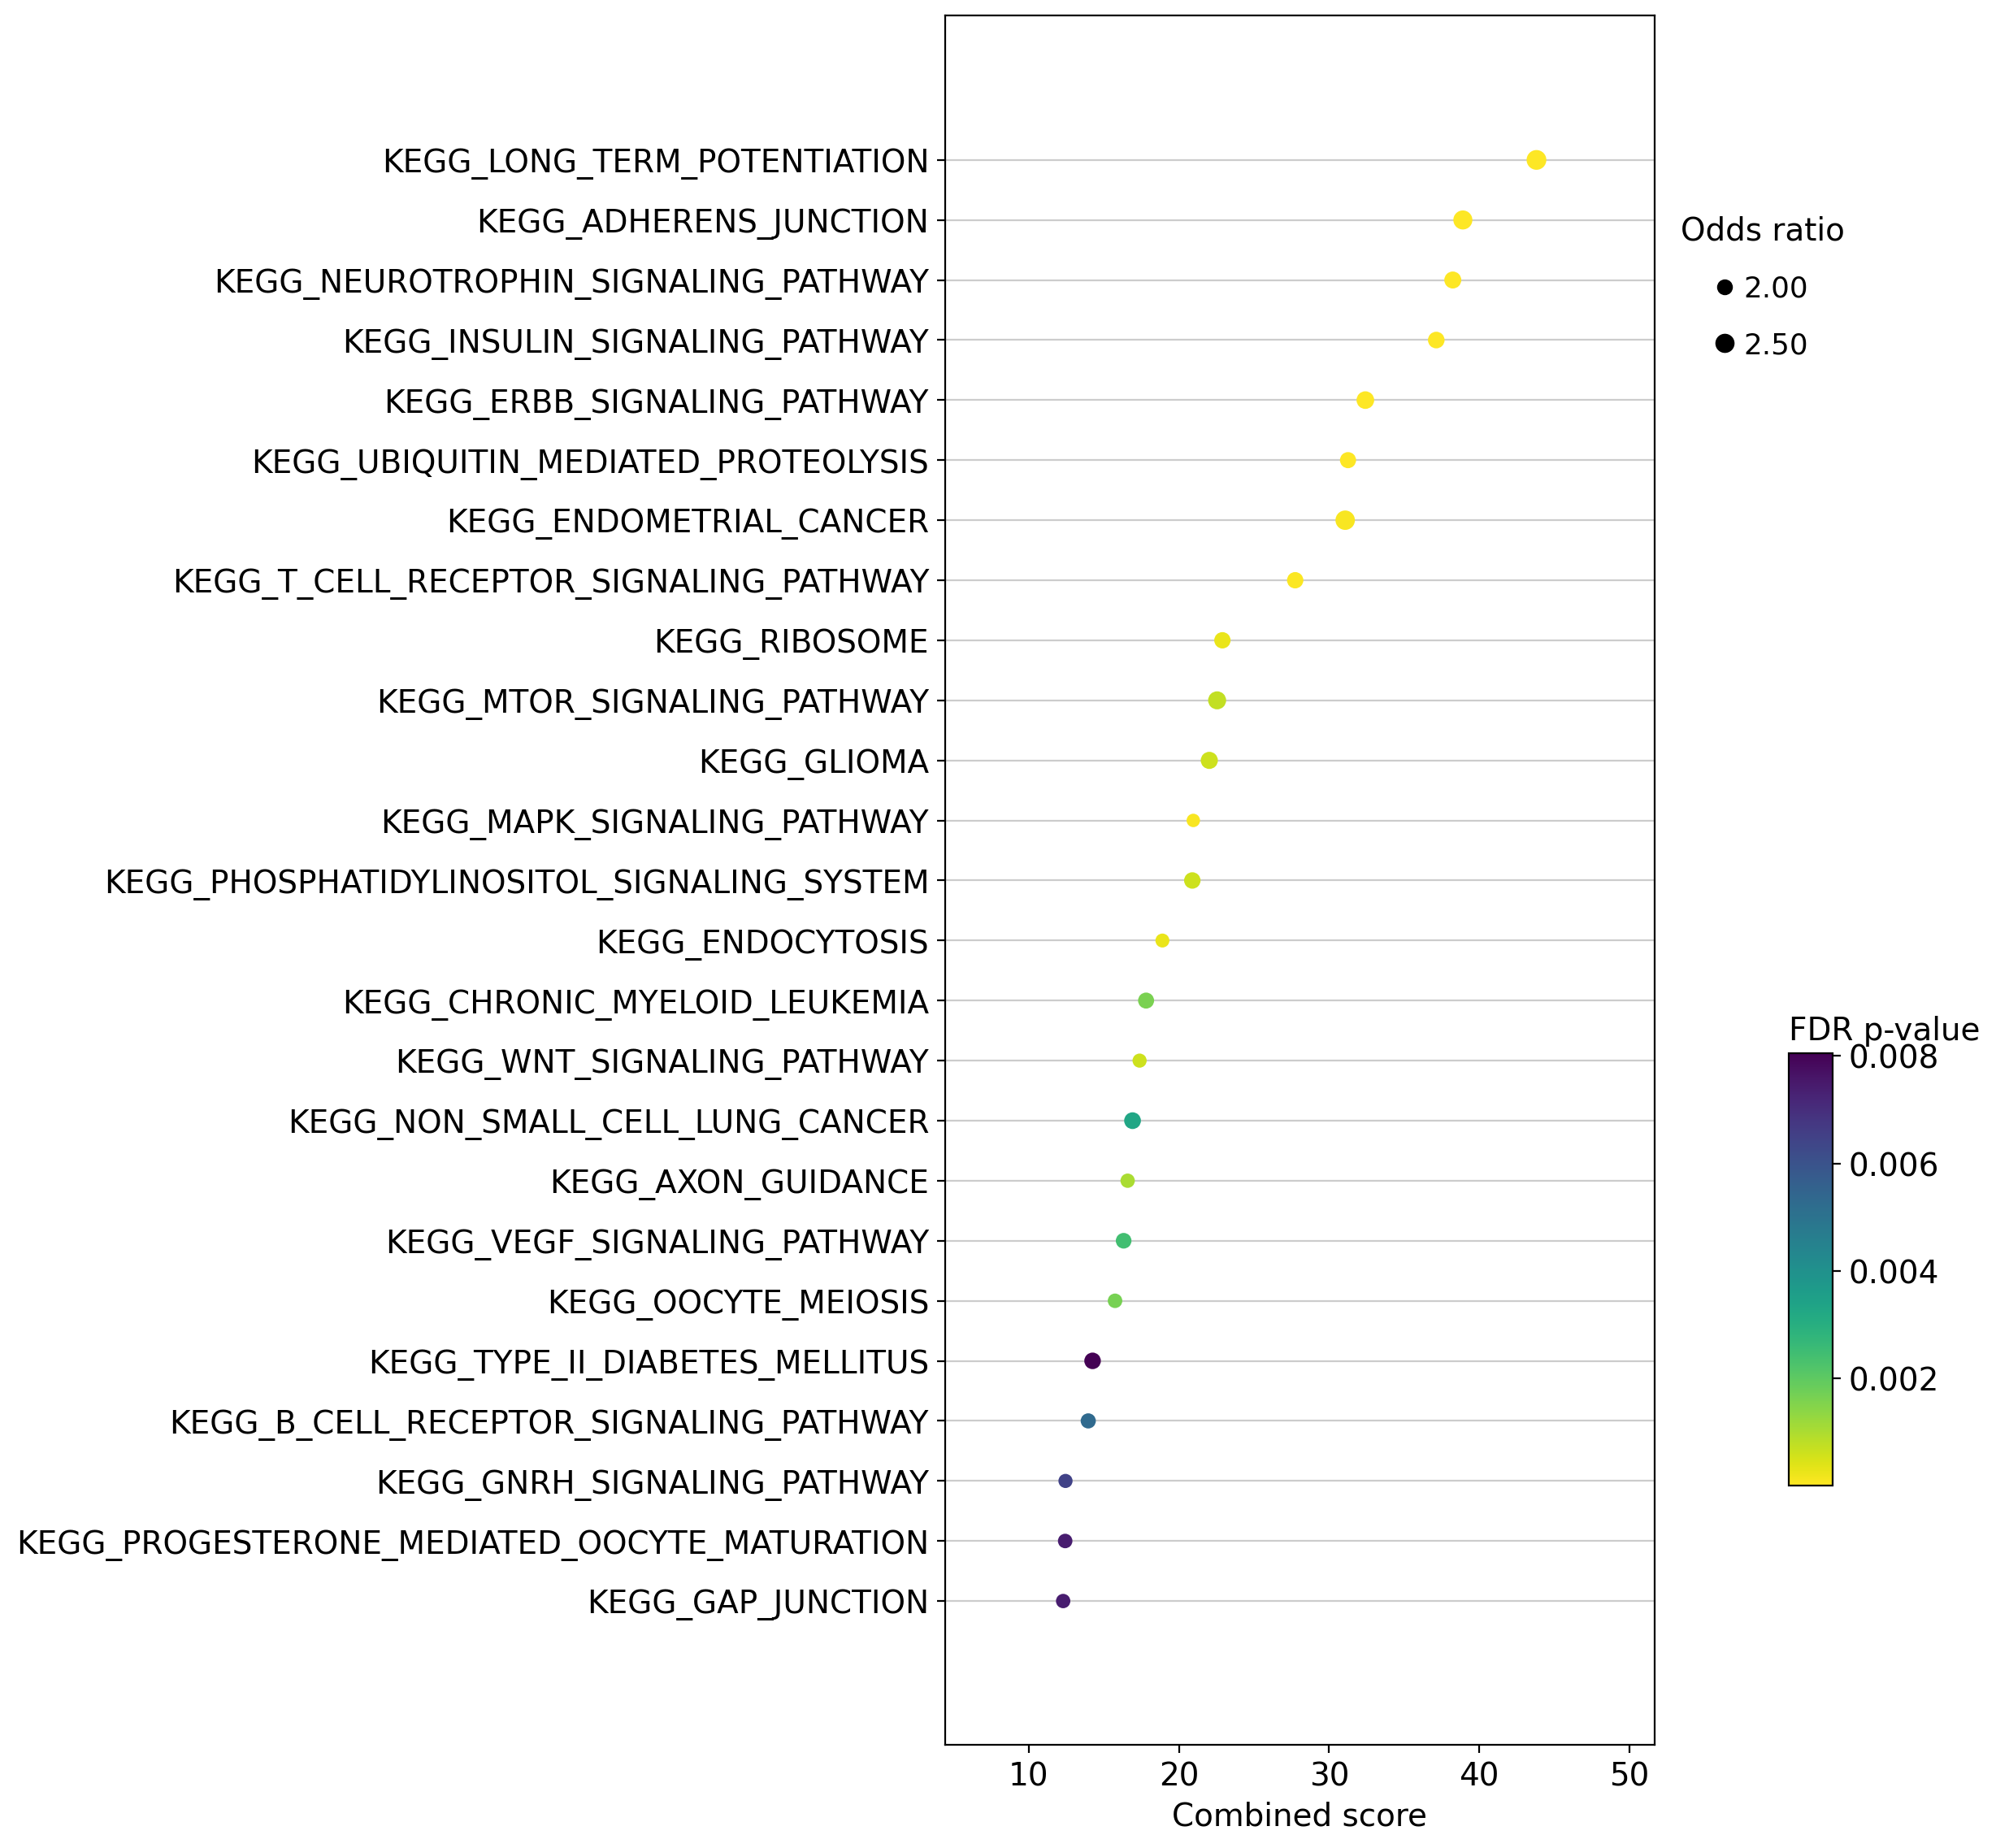

In [64]:
# Plot the dotplot
dc.plot_dotplot(
    enr_pvals, 
    x='Combined score', 
    y = 'Term', 
    s='Odds ratio', 
    c = 'FDR p-value', 
    scale = 0.5, 
    figsize=(7,14), 
    save=os.path.join(out_dir, f"SC_beta_{condition}_gsea_dotplot.png")
)

In [30]:
# Save the enrichment table
enr_pvals.to_csv(os.path.join(out_dir, f"SC_beta_{condition}_gsea_enrichment.tsv"), sep="\t")

# 

# DONE!

---

# Scratch

## Close analysis of particular sets
Will likely by separate custom notebook that will vary a lot from dataset to dataset

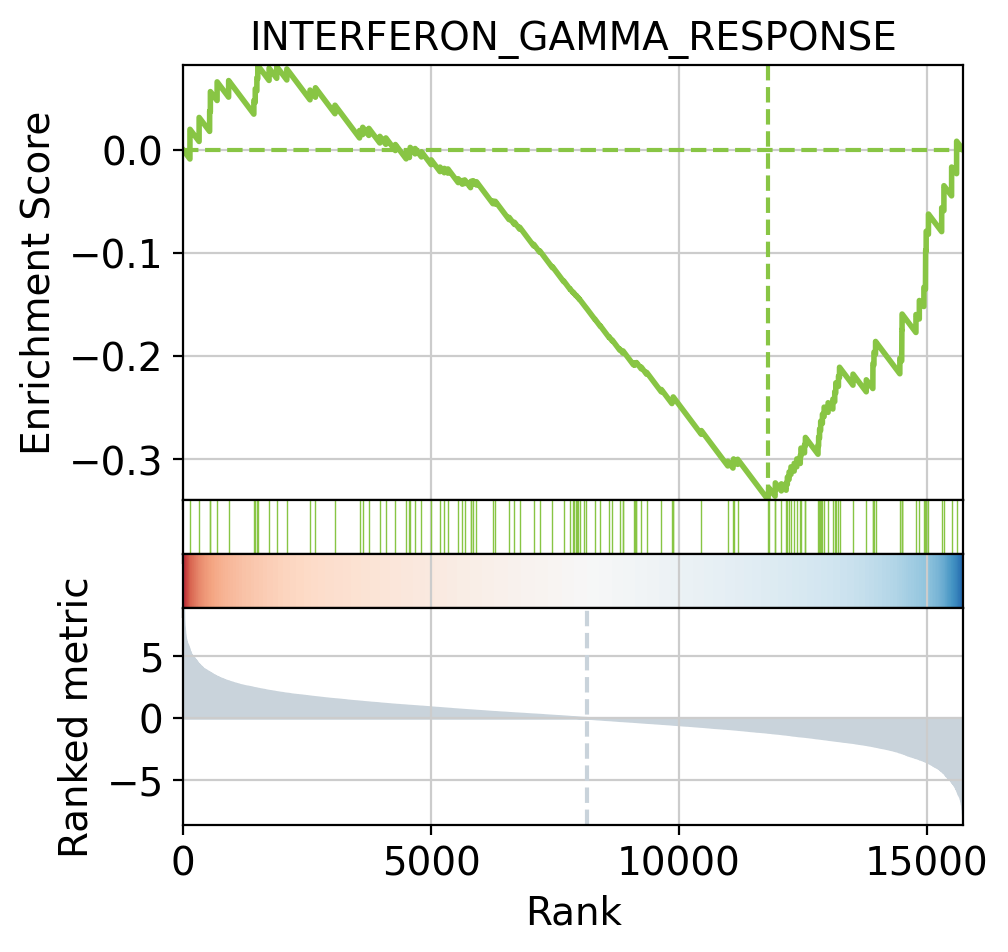

In [ ]:
# Plot
dc.plot_running_score(results_df, stat='stat', net=msigdb, source = 'geneset', target='genesymbol', set_name='INTERFERON_GAMMA_RESPONSE')